In [1]:
%run StoreTweetsBackend.ipynb

Growth SET
GPU ACTIVE
{'limit': 15, 'remaining': 15, 'reset': 1616209543}
{'limit': 900, 'remaining': 900, 'reset': 1616209543}
sentimentDB exists.
Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'sentimentDB')


# Sentiment

## Load Tweet Data

https://www.kaggle.com/omermetinn/tweets-about-the-top-companies-from-2015-to-2020

In [37]:
# datasets=["Company.csv","Company_Tweet.csv","Tweet.csv"]
# tweetdata= (pd.read_csv("D:/Downloads/archive (1)/{0}".format(datasets[2]),parse_dates=[0])).sort_values('post_date')
# tweetdata=tweetdata.set_index(pd.to_datetime(tweetdata["post_date"], unit='s',utc=True).dt.date)
# tweetdata=tweetdata.drop(columns=["writer","tweet_id",'post_date',"comment_num","retweet_num","like_num"])
# tweetdata=load("tweetdata")

Sentiment140

In [61]:
sentiment140Value=(getQueryFromMongoDB("processedSentiment140").sort_values('SentimentScore'))[["_id",'SentimentScore','processed']]
sentiment140Value=sentiment140Value.sample(frac=1)
sentiment140Value=sentiment140Value.drop_duplicates(subset=['processed'])
trainX, testX, trainY, testY =train_test_split(sentiment140Value['processed'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

## Creating a Tweet Preprocessor

In [43]:
punctuations=set(string.punctuation)
stopwordset=set(stopwords.words('english'))
stopwordsetNP=[re.sub(r"[^\ 0-9a-zA-Z]+",r"",w) for w in stopwordset]
trans=str.maketrans('','',string.punctuation)

In [23]:
from nltk.corpus import stopwords
class processer():
    def __init__(self,stemmer=None,tokenize=False,stopword=True, lower=True,links=True,retweets=True, users=True, hashtags=True, specialChars=True, nums=True, shortenBegin=True,repeats=True):
        self.stopwordset=[]
        if stopword: self.stopwordset=[word.translate(trans) for word in stopwords.words('english')]#Optimization
        self.regex=r"^"
        self.lower=lower
        self.stemmer=stemmer
        self.stopword=stopword
        self.tokenize=tokenize
        if links:        self.regex=self.regex+r"|(((((https?)?:\/\/)(www\.)?|www\.))([a-z0-9.]+)(\.[a-z]{2,4})(\.[a-z]{1,2})?([^?\s]+(\?((\w+)(=[^&\s]+)?&?)+)?)?)"
        if retweets:     self.regex=self.regex+r"|(RT \@[a-zA-Z0-9_.]*: )"
        if users:        self.regex=self.regex+r"|(\@[a-zA-Z0-9_.]* )"
        if hashtags:     self.regex=self.regex+r"|(\#[a-zA-Z0-9_%]*)"
        if specialChars: self.regex=self.regex+r"|([^\ 0-9a-zA-Z]+)"
        if nums:         self.regex=self.regex+r"|([0-9]*)"
        self.shortenBegin=shortenBegin
        self.repeats=repeats
    def stopW(self,sentence):
        sentence=sentence.split()
        temp=[]
        for word in sentence:
            if word not in self.stopwordset: #fix here
                if self.stemmer is not None: word=self.stemmer(word)
                temp.append(word)
        if self.tokenize: return temp
        return " ".join(temp)
    def process(self, sentence):
        if self.lower: sentence= sentence.lower()
        sentence = re.sub(self.regex,"",sentence)
        if self.shortenBegin: sentence = re.sub(r" (.)\1{1,}",r" \1",sentence)
        if self.repeats: sentence = re.sub(r"(.)\1{2,}",r"\1\1",sentence)
        if self.stopword: sentence= self.stopW(sentence)
        return sentence
#convert to unicode 

In [124]:
def processDF(dataframe, shortenBegin=True, repeats=True, lower=True, stemmer=None, removeWords=None, links=None,retweets=None, users=None, hashtags=None, specialChars=None, nums=None):
    if lower: dataframe=dataframe.str.lower()
    if links is not None: 
        dataframe=dataframe.replace(to_replace =r"(((((https?)?:\/\/)(www\.)?|www\.))([a-z0-9.]+)(\.[a-z]{2,4})(\.[a-z]{1,2})?([^?\s]+(\?((\w+)(=[^&\s]+)?&?)+)?)?)", value =links, regex = True)
    if retweets is not None:
        dataframe=dataframe.replace(to_replace =r"(RT \@[a-zA-Z0-9_.]*: )", value =retweets, regex = True)
    if users is not None: 
        dataframe=dataframe.replace(to_replace =r"(\@[a-zA-Z0-9_.]* )", value =users, regex = True)
    if hashtags is not None: 
        dataframe=dataframe.replace(to_replace =r"(\#[a-zA-Z0-9_%]*)", value =hashtags, regex = True)
    if specialChars is not None: 
        dataframe=dataframe.replace(to_replace =r"([^\ 0-9a-zA-Z]+)", value =specialChars, regex = True)
    if nums is not None: 
        dataframe=dataframe.replace(to_replace =r"([0-9]*)", value =nums, regex = True)
    if shortenBegin:
        dataframe=dataframe.replace(to_replace =r" (.)\1{1,}", value =r" \1", regex = True)
    if repeats:
        dataframe=dataframe.replace(to_replace =r"(.)\1{2,}", value =r"\1\1", regex = True)
    if removeWords is not None:
        dataframe=dataframe.replace(to_replace =removeWords, value =r"", regex = True)
#         r"(\b[a-zA-Z]\b)"
    if stemmer is not None:
        dataframe=dataframe.apply(lambda x: ' '.join([stemmer(w) for w in x.split()]))
    return dataframe
s=time.time()
sentiment140Value["processed"]=processDF(sentiment140Value['tweetText'],
          shortenBegin=True, repeats=True, lower=True, stemmer=stemm,
          removeWords=r'\b({})\b'.format('|'.join(stopwordsetNP)), links=' ',retweets=' ',
          users=' ', hashtags=' ', specialChars='', nums='')
time.time()-s

97.95790266990662

Fix stopwords and stemmer being attached

In [24]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
stemm=lemmatizer.lemmatize
p=processer(stemmer=stemm, tokenize=False, stopword=True, lower=True, links=True,
            retweets=True, users=True, hashtags=True, specialChars=True, 
            nums=True, shortenBegin=True ,repeats=True)
print(p.regex)

^|(((((https?)?:\/\/)(www\.)?|www\.))([a-z0-9.]+)(\.[a-z]{2,4})(\.[a-z]{1,2})?([^?\s]+(\?((\w+)(=[^&\s]+)?&?)+)?)?)|(RT \@[a-zA-Z0-9_.]*: )|(\@[a-zA-Z0-9_.]* )|(\#[a-zA-Z0-9_%]*)|([^\ 0-9a-zA-Z]+)|([0-9]*)


### Text Preprocessing

In [276]:
# tweetdata["processed"]=tweetdata["body"].apply(p.process)
# tweetdata=tweetdata.drop_duplicates(subset=['body'])
# dump(tweetdata,"tweetdata")
# tweetdata=load("tweetdata")

### Testing Various Input Configurations 

In [277]:
binary=["binary"]
original3=["original3"]
hinge=["hinge"]
cat2=["C2-bad","C2-good"]
cat3=["C3-bad","C3-Neutral","C3-good"]
cat5=["C5-very bad","C5-bad","C5-Neutral","C5-good","C5-very good"]
sentiment140Value[original3]=sentiment140Value['SentimentScore'].replace({4: 2})#binary
sentiment140Value[binary]=sentiment140Value['SentimentScore'].replace({4: 1})#binary
sentiment140Value[hinge]=sentiment140Value['SentimentScore'].replace({4: 1,0: -1})#Hinge/sq
sentiment140Value[cat2]=to_categorical(sentiment140Value['SentimentScore'].replace({4: 1}))
sentiment140Value[cat3]=to_categorical(sentiment140Value['SentimentScore'].replace({4: 2,0: 0}))
sentiment140Value[cat5]=to_categorical(sentiment140Value['SentimentScore'])

In [278]:
allscores=[]
allscores.extend(binary)
allscores.extend(hinge)
allscores.extend(cat2)
allscores.extend(cat3)
allscores.extend(cat5)
allscores.extend(original3)
allscores.extend(['SentimentScore'])

In [279]:
trainX, testX, trainY, testY =train_test_split( sentiment140Value['processed'], sentiment140Value[allscores],shuffle=True, test_size=0.2)

In [280]:
model = Pipeline([
        ('bow', CountVectorizer(preprocessor=p.process,ngram_range=(1,3),lowercase=False)),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
    ])
    
# model= getSentimentModel(ngram=(1,3))
model.fit(trainX, trainY)
pred=model.predict(testX)
print(confusion_matrix(testY,pred))
print(classification_report(testY,pred))

NameError: name 'p' is not defined

### Binary

In [283]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(1,activation="sigmoid")) 
    M.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[binary],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

3614094
Epoch 1/100
5303/5303 [==============================] - 2179s 409ms/step - loss: 0.5016 - accuracy: 0.7505 - val_loss: 0.4487 - val_accuracy: 0.7890
Epoch 2/100
5303/5303 [==============================] - 2028s 382ms/step - loss: 0.1796 - accuracy: 0.9290 - val_loss: 0.6600 - val_accuracy: 0.7252
Epoch 3/100
5303/5303 [==============================] - 1998s 377ms/step - loss: 0.0647 - accuracy: 0.9749 - val_loss: 0.8579 - val_accuracy: 0.7084
Epoch 4/100
5303/5303 [==============================] - 2000s 377ms/step - loss: 0.0283 - accuracy: 0.9889 - val_loss: 1.2411 - val_accuracy: 0.6993


In [284]:
model.save("Binary")
model=tf.keras.models.load_model('Binary')

INFO:tensorflow:Assets written to: Binary\assets


INFO:tensorflow:Assets written to: Binary\assets


### Hinge

In [285]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(1,activation='tanh')) 
    M.compile(optimizer=optimizer,loss="hinge",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='tanh',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[hinge],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

3614094
Epoch 1/100
5303/5303 [==============================] - 2029s 381ms/step - loss: 0.5524 - accuracy: 0.3314 - val_loss: 0.4692 - val_accuracy: 0.3636
Epoch 2/100
5303/5303 [==============================] - 2028s 382ms/step - loss: 0.3343 - accuracy: 0.4096 - val_loss: 0.4808 - val_accuracy: 0.3618
Epoch 3/100
5303/5303 [==============================] - 2028s 383ms/step - loss: 0.2551 - accuracy: 0.4297 - val_loss: 0.4752 - val_accuracy: 0.3716
Epoch 4/100
5303/5303 [==============================] - 2026s 382ms/step - loss: 0.2172 - accuracy: 0.4416 - val_loss: 0.4737 - val_accuracy: 0.3841
Epoch 5/100
5303/5303 [==============================] - 2027s 382ms/step - loss: 0.1967 - accuracy: 0.4483 - val_loss: 0.4803 - val_accuracy: 0.3797
Epoch 6/100
5303/5303 [==============================] - 2027s 382ms/step - loss: 0.1845 - accuracy: 0.4495 - val_loss: 0.4736 - val_accuracy: 0.3894
Epoch 7/100
5303/5303 [==============================] - 2027s 382ms/step - loss: 0.1727 - a

In [286]:
model.save("hinge")
model=tf.keras.models.load_model('hinge')

INFO:tensorflow:Assets written to: hinge\assets


INFO:tensorflow:Assets written to: hinge\assets


SQHinge

In [287]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(1,activation='tanh')) 
    M.compile(optimizer=optimizer,loss="squared_hinge",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='tanh',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[hinge],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

3614094
Epoch 1/100
5303/5303 [==============================] - 2000s 376ms/step - loss: 0.6659 - accuracy: 0.2175 - val_loss: 0.5848 - val_accuracy: 0.2504
Epoch 2/100
3728/5303 [====================>.........] - ETA: 9:55 - loss: 0.2148 - accuracy: 0.4299

KeyboardInterrupt: 

In [ ]:
model.save("squared_hinge")
model=tf.keras.models.load_model('squared_hinge')

### CAT

#### CAT2

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(2,activation='tanh')) 
    M.compile(optimizer=optimizer,loss="categorical_hinge",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='tanh5',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat2].replace({1: 1,0: -1}),epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat222")
model=tf.keras.models.load_model('cat222')

In [82]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(2,activation="softmax")) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
# H=model.fit(trainX, trainY[cat2],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

NameError: name 'trainX' is not defined

In [ ]:
model.save("cat2")
model=tf.keras.models.load_model('cat2')

In [290]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(2,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="kullback_leibler_divergence",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat2],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [289]:
model.save("cat22")
model=tf.keras.models.load_model('cat22')

INFO:tensorflow:Assets written to: cat22\assets


INFO:tensorflow:Assets written to: cat22\assets


#### CAT3

In [427]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(3,activation='tanh')) 
    M.compile(optimizer=optimizer,loss="categorical_hinge",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='tanh',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat3].replace({1: 1,0: -1}),epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [426]:
model.save("cat333")
model=tf.keras.models.load_model('cat333')

INFO:tensorflow:Assets written to: cat333\assets


INFO:tensorflow:Assets written to: cat333\assets


In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(3,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat3],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat3")
model=tf.keras.models.load_model('cat3')

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(3,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="kullback_leibler_divergence",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat3],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat33")
model=tf.keras.models.load_model('cat33')

#### CAT5

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(5,activation='tanh')) 
    M.compile(optimizer=optimizer,loss="categorical_hinge",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='tanh',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat5].replace({1: 1,0: -1}),epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat555")
model=tf.keras.models.load_model('cat555')

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(5,activation='softmax')) 
    M.compile(optimizer=optimizer, loss="categorical_crossentropy",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat5],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat5")
model=tf.keras.models.load_model('cat5')

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(5,activation='softmax')) 
    M.compile(optimizer=optimizer, loss="kullback_leibler_divergence",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat5],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat55")
model=tf.keras.models.load_model('cat55')

### Original3

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(3,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[original3],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("original3")
model=tf.keras.models.load_model('original3')

Original5

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(5,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY["SentimentScore"],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("original5")
model=tf.keras.models.load_model('original5')

Creating a preprocessor object

## Training & evaluating a model

In [ ]:
# sentiment140Value=(getQueryFromMongoDB("processedSentiment140"))[["_id",'SentimentScore','processed']]
# sentiment140Value=sentiment140Value.sample(frac=1)
# sentiment140Value=sentiment140Value.drop_duplicates(subset=['processed'])
# trainX, testX, trainY, testY =train_test_split(sentiment140Value['processed'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

In [ ]:
# trainX, testX, trainY, testY =train_test_split(sentiment140Value['tweetText'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

In [ ]:
# model= getSentimentModel(ngram=(1,3))
# model.fit(trainX, trainY) 
# pred=model.predict(testX)
# print(confusion_matrix(testY,pred))
# print(classification_report(testY,pred))

In [257]:
# def BiLSTM_model(dataset,vocab_size = 5000, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
#     vec_layer = TextVectorization(
#         standardize=None, 
#         output_mode=mode,    #"int", "binary", "count" or "tf-idf"
#         ngrams=ngram,
# #         max_tokens=vocab_size,
#         pad_to_max_tokens=True,
#         output_sequence_length=sequence_length
#                         )
#     vec_layer.adapt(dataset)
#     M = Sequential()
#     M.add(vec_layer),
#     M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
#     M.add(Bidirectional(LSTM(embedding_dim)))
#     M.add(Dense(hidden, activation='relu'))
#     M.add(Dense(2, activation='softmax'))    
#     M.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=["CategoricalAccuracy"])  
#     return M

## Experiment Results

# Stock Forecasting

## Load Data

In [ ]:
# MSFT=loadStockData("MSFT")

Split by time period

train validate test
train+validation Test
train+validate+test

moving average removes trend and seasonality
can be worse than regular time series

remove trend and seasonality using differencing avoids learning the trend but learned the differences between the periods
get a moving average of that or not and predict

series + moving avg of differenced
trailing moving average of differenced + centered moving average of past series

Take original data and shift by 1 timestep and call that baseline

split data into its seasons -> moving avg +past values m

normalization

shuffle to avoid sequence bias

error MSE RMSE MAE MAPE

In [51]:
MSFT=load("MSFT")
data=MSFT.sort_values('Date')
print("NULLs\n\n",data.isnull().sum())
print(data.index.min(), data.index.max())
cols = [ "OpenInt"]
data.drop(columns=["Dividends","Stock Splits"],inplace=True)
# data

NULLs

 Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
1986-03-13 00:00:00 2021-03-15 00:00:00


## Data Exploration

In [52]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
# limit_direction{{‘forward’, ‘backward’, ‘both’}}
data=data.resample('D').first()
data["wasNa"]=data['Close'].isna()#mark filled in spots for future reference
data=data.interpolate(method='polynomial', order=2, limit_direction='both')
# print("NULLs\n",data2.isnull().sum())
# data2

In [53]:
data

,Open,High,Low,Close,Volume,wasNa
Date,,,,,,
1986-03-13,0.056238,0.064508,0.056238,0.061751,1.031789e+09,False
1986-03-14,0.061751,0.065059,0.061751,0.063956,3.081600e+08,False
1986-03-15,0.063998,0.065355,0.064447,0.065314,2.171001e+07,True
1986-03-16,0.063564,0.065442,0.064613,0.065776,1.027527e+08,True
1986-03-17,0.063956,0.065610,0.063956,0.065059,1.331712e+08,False
...,...,...,...,...,...,...
2021-03-11,234.960007,239.169998,234.309998,237.130005,2.989600e+07,False
2021-03-12,234.009995,235.820007,233.229996,235.750000,2.264790e+07,False
2021-03-13,233.848545,233.393942,232.078253,234.178017,1.851487e+07,True


## Fill Gaps

USing imputation

Auto Correlation 
trend
Seasonality

In [126]:
# insterDFToDB("processedSentiment140",sentiment140Value[["_id","SentimentScore","processed"]])

In [ ]:
# TSLA=load("TSLA")
# print(tweetdata["post_date"].min(), tweetdata["post_date"].max())
# print(TSLA.index.min(), TSLA.index.max())
# mini,maxi=None,None
# if tweetdata["post_date"].min()>TSLA.index.min(): mini=tweetdata["post_date"].min()
# else: mini= TSLA.index.min()
# if tweetdata["post_date"].max()>TSLA.index.max(): mini=TSLA.index.max()
# else: maxi= tweetdata["post_date"].max()
# print(mini,"-",maxi)

In [4]:
# check if stock has relationship with sentiment
# check if sentiment compenent works well
# check if sentiment compenent improves stock predictions 
# check if fill in and check missing data in time series problems
# check how roll calculates missing values 

In [7]:
tslaTweets=tweetdata[tweetdata["body"].str.contains("tsla")]
tslaTweets["sentiment"]=model.predict(tslaTweets["body"])
tslaTweets["good"],tslaTweets["bad"]=tslaTweets["sentiment"].apply(lambda x: x==4 and 1 or 0),tslaTweets["sentiment"].apply(lambda x: x==0 and 1 or 0)
tslaTweets=tslaTweets.groupby(tslaTweets.index).sum()
tslaTweets=tslaTweets.set_index(pd.to_datetime(tslaTweets.index))

<ipython-input-7-a6499a5f6258>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tslaTweets["sentiment"]=model.predict(tslaTweets["body"])
<ipython-input-7-a6499a5f6258>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tslaTweets["good"],tslaTweets["bad"]=tslaTweets["sentiment"].apply(lambda x: x==4 and 1 or 0),tslaTweets["sentiment"].apply(lambda x: x==0 and 1 or 0)


In [9]:
# tslaTweets
# findMissingInterval(tslaTweets)

In [10]:
# slices.drop(columns=['sentiment'], inplace=True)
tslaTweets["diff"]=tslaTweets["good"]-tslaTweets["bad"]
tslaTweets["str"]=tslaTweets["diff"]/(tslaTweets["good"]+tslaTweets["bad"])
tslaTweets["sign"]=np.sign(tslaTweets["diff"])
tslaTweets["change"]=(tslaTweets["diff"]-tslaTweets["diff"].shift(1)).fillna(0)
tslaTweets["changeS"]=np.sign(tslaTweets["change"])
tslaTweets=tslaTweets.resample('D').first()
tslaTweets=tslaTweets.ffill()

In [15]:
tslaTweets.index.max(),tslaTweets.index.min(),data2.index.max(),data2.index.min()

(Timestamp('2019-12-31 00:00:00', freq='D'),
 Timestamp('2015-01-01 00:00:00', freq='D'),
 Timestamp('2021-03-15 00:00:00', freq='D'),
 Timestamp('1986-03-13 00:00:00', freq='D'))

In [16]:
mini=tslaTweets.index.min()
maxi=tslaTweets.index.max()

<AxesSubplot:>

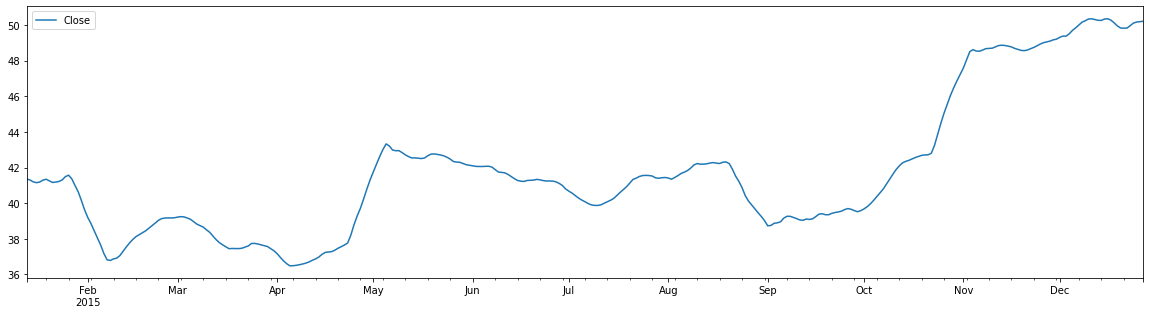

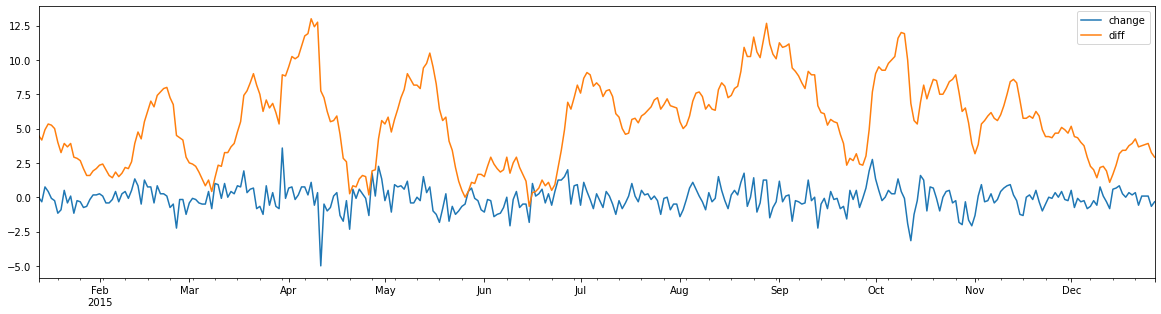

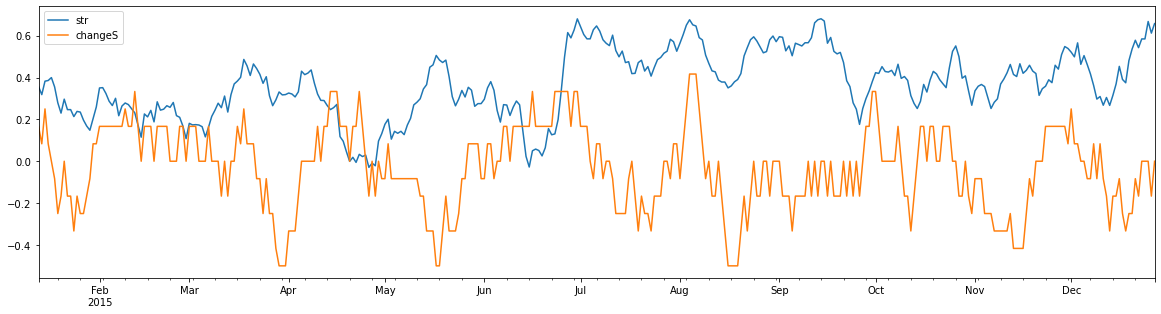

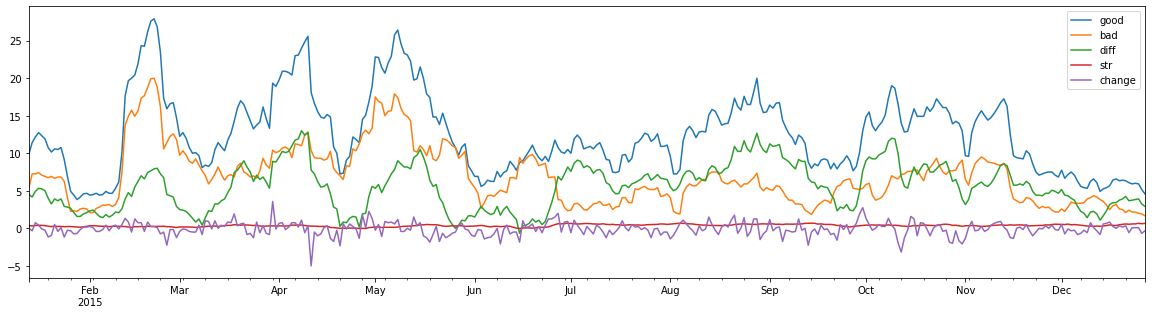

In [17]:
fromD=mini+ timedelta(days=12)
to=mini+ timedelta(days=360)
common=pd.merge(left=data2, left_index=True, right=tslaTweets, right_index=True)
commonr=common.rolling(12).mean().dropna()
commonr[fromD:to][["Close"]].plot(xlim=(fromD,to))
commonr[fromD:to][["change","diff"]].plot(xlim=(fromD,to))
commonr[fromD:to][["str","changeS"]].plot(xlim=(fromD,to))
commonr[fromD:to][['good', 'bad', 'diff', 'str', 'change']].plot(xlim=(fromD,to))

## Testing Different Models Performance

Shuffle vs No shuffling (1D vs 2D)

Try training Model From all Available stocks

In [54]:
period=5

In [55]:
def createTimeSeriesData(data,shifts=5,backfill=False):
    temp=data
    for i in range(1,shifts):
        temp=pd.merge(left=data.shift(i), left_index=True, right=temp ,right_index=True)
    if backfill: return temp.fillna(method='backfill',axis=1)
    return temp.dropna()[:-1]

In [56]:
dataIn=createTimeSeriesData(data[["Close"]],shifts=period,backfill=False)
dataOut=data[["Close"]].shift(-period).dropna()
dataIn=(dataIn.to_numpy().reshape(dataIn.shape[0],5,1))

In [57]:
tx,vx,ty,vy=train_test_split(dataIn,dataOut,test_size=0.1,shuffle=False)

In [58]:
tx.shape,ty.shape

((11503, 5, 1), (11503, 1))

### BILSTM

In [383]:
lr_shedule=tf.keras.callbacks.LearningRateScheduler( lambda x: 1e-8*10**(x/20))

Epoch 1/500
96/96 [==============================] - 2s 7ms/step - loss: 12.9707 - val_loss: 47.8174
Epoch 2/500
96/96 [==============================] - 0s 3ms/step - loss: 10.1077 - val_loss: 36.5117
Epoch 3/500
96/96 [==============================] - 0s 3ms/step - loss: 2.7968 - val_loss: 26.1607
Epoch 4/500
96/96 [==============================] - 0s 3ms/step - loss: 0.7123 - val_loss: 22.2946
Epoch 5/500
96/96 [==============================] - 0s 3ms/step - loss: 0.4442 - val_loss: 19.9698
Epoch 6/500
96/96 [==============================] - 0s 3ms/step - loss: 0.3371 - val_loss: 18.3184
Epoch 7/500
96/96 [==============================] - 0s 3ms/step - loss: 0.2895 - val_loss: 17.0868
Epoch 8/500
96/96 [==============================] - 0s 3ms/step - loss: 0.2652 - val_loss: 16.1012
Epoch 9/500
96/96 [==============================] - 0s 3ms/step - loss: 0.2485 - val_loss: 15.3425
Epoch 10/500
96/96 [==============================] - 0s 3ms/step - loss: 0.2412 - val_loss: 14.73

96/96 [==============================] - 0s 3ms/step - loss: 0.1925 - val_loss: 10.4046
Epoch 163/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1939 - val_loss: 10.4419
Epoch 164/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1873 - val_loss: 10.3262
Epoch 165/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1941 - val_loss: 10.3660
Epoch 166/500
96/96 [==============================] - 0s 4ms/step - loss: 0.1936 - val_loss: 10.4313
Epoch 167/500
96/96 [==============================] - 0s 3ms/step - loss: 0.2014 - val_loss: 10.4164
Epoch 168/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1862 - val_loss: 10.4365
Epoch 169/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1936 - val_loss: 10.4113
Epoch 170/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1935 - val_loss: 10.3827
Epoch 171/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1905 - val_loss: 10

96/96 [==============================] - 0s 3ms/step - loss: 0.1963 - val_loss: 10.2018
Epoch 323/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1953 - val_loss: 10.2158
Epoch 324/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1952 - val_loss: 10.1630
Epoch 325/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1875 - val_loss: 10.0896
Epoch 326/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1934 - val_loss: 10.1129
Epoch 327/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1897 - val_loss: 10.1326
Epoch 328/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1953 - val_loss: 10.1763
Epoch 329/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1910 - val_loss: 10.1960
Epoch 330/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1904 - val_loss: 10.1678
Epoch 331/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1954 - val_loss: 10

96/96 [==============================] - 0s 3ms/step - loss: 0.1938 - val_loss: 9.8957
Epoch 483/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1976 - val_loss: 9.9718
Epoch 484/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1838 - val_loss: 9.9445
Epoch 485/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1905 - val_loss: 9.9709
Epoch 486/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1974 - val_loss: 9.9296
Epoch 487/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1944 - val_loss: 9.9610
Epoch 488/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1957 - val_loss: 9.8649
Epoch 489/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1901 - val_loss: 9.9223
Epoch 490/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1856 - val_loss: 9.8457
Epoch 491/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1949 - val_loss: 9.9731
Epoc

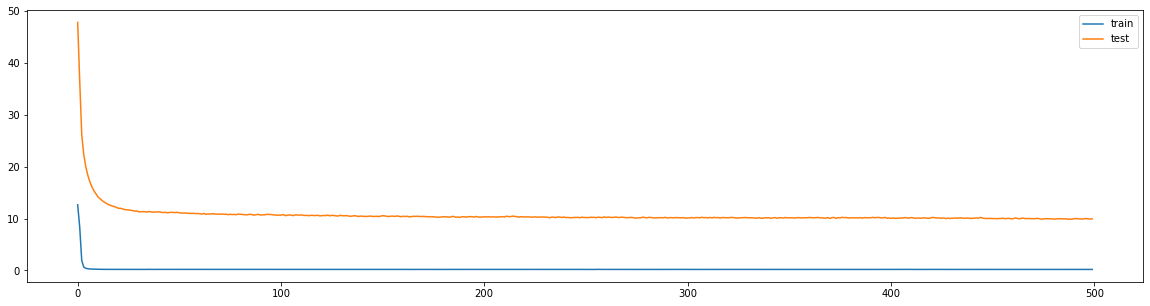

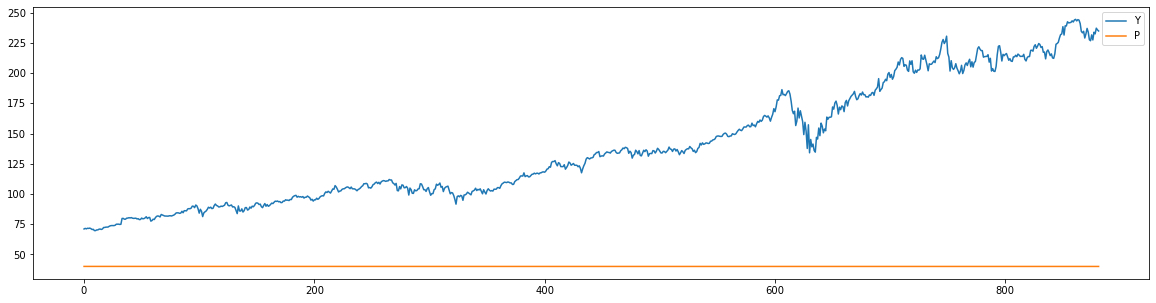

In [424]:
from keras.optimizers import SGD
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=100)]

def BILSTM_model(inputShape, lstm=5,activation='relu',optimizer='adam',hidden=16):
    M = Sequential()
#     M.add(LSTM(lstm,activation=tf.keras.layers.LeakyReLU(),return_sequences=True ,input_shape=inputShape))
#     M.add(Bidirectional(LSTM(5,activation="relu",return_sequences=False ,input_shape=trainX.shape[1:])))
#     M.add(Bidirectional(LSTM(lstm,input_shape=inputShape,return_sequences=True)))
#     M.add(Bidirectional(LSTM(5,return_sequences=True ,input_shape=inputShape)))
#     M.add(tf.keras.layers.LeakyReLU())
    M.add(LSTM(lstm,input_shape=inputShape,return_sequences=False))
#     M.add(LSTM(lstm,activation=tf.keras.layers.LeakyReLU(),return_sequences=False ,input_shape=inputShape))
    M.add(Dense(hidden, activation=activation))
    M.add(Dense(1))
#     M.compile(loss='mae', optimizer=SGD(lr=0.1, momentum=0.9))
    M.compile(optimizer='adam',loss='mae')
#     M.compile(loss='mean_squared_error', optimizer='adam')
#     model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])
#     M.compile(loss='mean_squared_logarithmic_error', optimizer=opt)
#     M.compile(optimizer=opt,loss='mae')  
    return M
model=BILSTM_model(inputShape=tx.shape[1:],lstm=16,activation='relu',optimizer='adam',hidden=16)
history = model.fit(tx, ty, epochs=500, shuffle=True, batch_size=75, validation_split=0.1, callbacks=callbacks)
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
predictions=model.predict(vx)
predictions.shape
plotCompare(vy.values,predictions,["Y","P"])

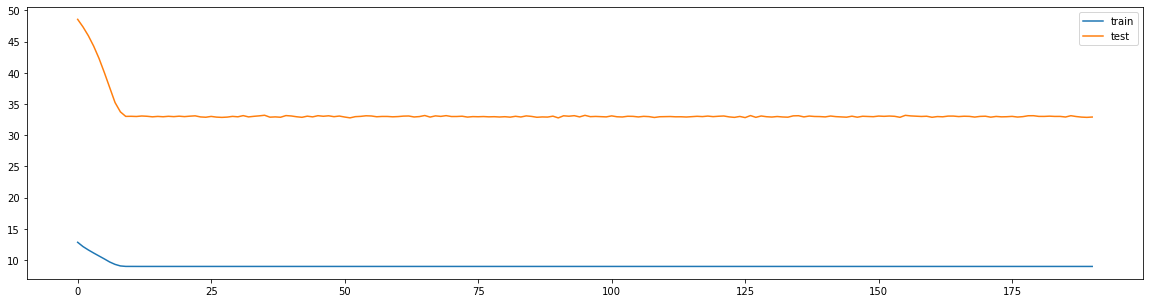

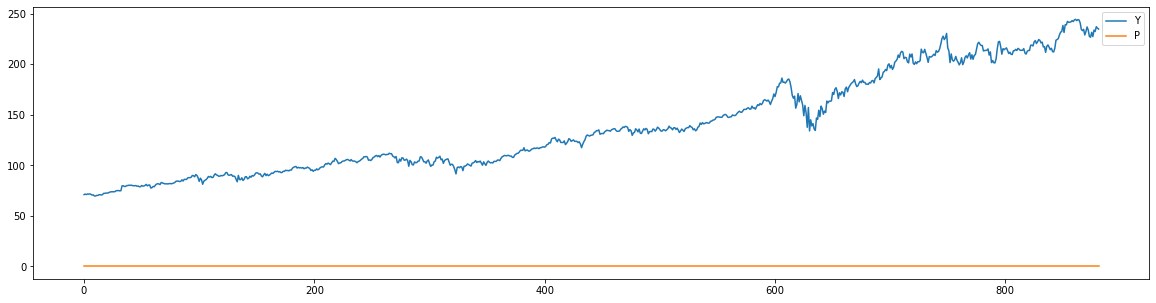

In [388]:
# plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
# predictions=model.predict(vx)
# predictions.shape
# plotCompare(vy.values,predictions,["Y","P"])

Epoch 1/500
96/96 [==============================] - 2s 7ms/step - loss: 11.6742 - val_loss: 43.5497
Epoch 2/500
96/96 [==============================] - 0s 3ms/step - loss: 6.3980 - val_loss: 29.8964
Epoch 3/500
96/96 [==============================] - 0s 3ms/step - loss: 0.9491 - val_loss: 22.6381
Epoch 4/500
96/96 [==============================] - 0s 3ms/step - loss: 0.2969 - val_loss: 19.1522
Epoch 5/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1577 - val_loss: 16.9767
Epoch 6/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1161 - val_loss: 15.3965
Epoch 7/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0813 - val_loss: 14.2824
Epoch 8/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0745 - val_loss: 13.4802
Epoch 9/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0636 - val_loss: 12.9160
Epoch 10/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0624 - val_loss: 12.472

96/96 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 8.7970
Epoch 164/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0516 - val_loss: 8.8669
Epoch 165/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0546 - val_loss: 8.8502
Epoch 166/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 8.7517
Epoch 167/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 8.7495
Epoch 168/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0537 - val_loss: 8.7700
Epoch 169/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0545 - val_loss: 8.7410
Epoch 170/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0564 - val_loss: 8.8052
Epoch 171/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0577 - val_loss: 8.7818
Epoch 172/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 8.7538
Epoc

96/96 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 8.4677
Epoch 326/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0565 - val_loss: 8.6445
Epoch 327/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 8.5098
Epoch 328/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0516 - val_loss: 8.4879
Epoch 329/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 8.6251
Epoch 330/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0572 - val_loss: 8.5378
Epoch 331/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 8.5074
Epoch 332/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 8.6611
Epoch 333/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0582 - val_loss: 8.6165
Epoch 334/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0556 - val_loss: 8.6491
Epoc

96/96 [==============================] - 0s 4ms/step - loss: 0.0531 - val_loss: 8.2287
Epoch 488/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0549 - val_loss: 8.3571
Epoch 489/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0527 - val_loss: 8.1855
Epoch 490/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0571 - val_loss: 8.3550
Epoch 491/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0555 - val_loss: 8.1113
Epoch 492/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0605 - val_loss: 8.3528
Epoch 493/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0506 - val_loss: 8.2506
Epoch 494/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0518 - val_loss: 8.1694
Epoch 495/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0525 - val_loss: 8.3762
Epoch 496/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0529 - val_loss: 8.3159
Epoc

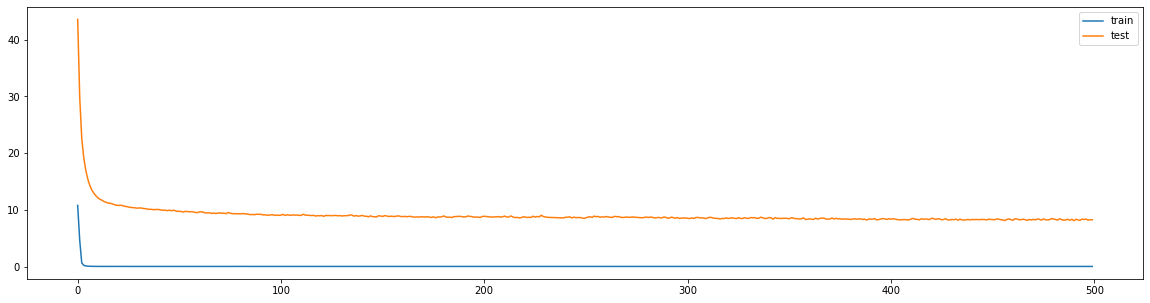

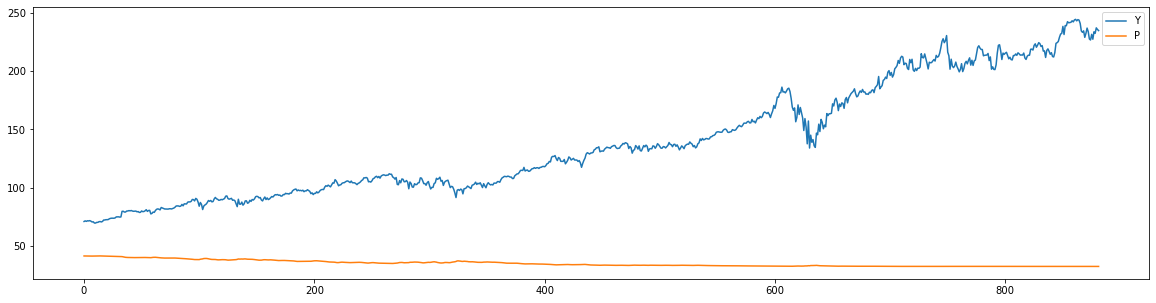

In [421]:
from keras.optimizers import SGD
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=100)]

def BILSTM_model(inputShape, lstm=5,activation='relu',optimizer='adam',hidden=16):
    M = Sequential()
#     M.add(LSTM(lstm,activation=tf.keras.layers.LeakyReLU(),return_sequences=True ,input_shape=inputShape))
#     M.add(Bidirectional(LSTM(5,activation="relu",return_sequences=False ,input_shape=trainX.shape[1:])))
#     M.add(Bidirectional(LSTM(lstm,input_shape=inputShape,return_sequences=True)))
#     M.add(Bidirectional(LSTM(lstm,return_sequences=True ,input_shape=inputShape)))
#     M.add(tf.keras.layers.LeakyReLU())
    M.add(LSTM(lstm,input_shape=inputShape,return_sequences=False))
#     M.add(LSTM(lstm,activation=tf.keras.layers.LeakyReLU(),return_sequences=False ,input_shape=inputShape))
    M.add(Dense(hidden, activation=activation))
    M.add(Dense(1,activation="linear"))
#     M.compile(loss='mae', optimizer=SGD(lr=0.1, momentum=0.9))
    M.compile(optimizer='adam',loss='huber')
#     M.compile(loss='mean_squared_error', optimizer='adam')
#     model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])
#     M.compile(loss='mean_squared_logarithmic_error', optimizer=opt)
    return M
model=BILSTM_model(inputShape=tx.shape[1:],lstm=16,activation='relu',optimizer='adam',hidden=16)
history = model.fit(tx, ty, epochs=500, shuffle=True, batch_size=75, validation_split=0.1, callbacks=callbacks)
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
predictions=model.predict(vx)
predictions.shape
plotCompare(vy.values,predictions,["Y","P"])

In [233]:
from keras.optimizers import SGD
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=100)]

def BILSTM_model(inputShape, lstm=5,activation='relu',optimizer='adam',hidden=16):
    M = Sequential()
#     M.add(LSTM(lstm,activation=tf.keras.layers.LeakyReLU(),return_sequences=True ,input_shape=inputShape))
#     M.add(Bidirectional(LSTM(5,activation="relu",return_sequences=False ,input_shape=trainX.shape[1:])))
#     M.add(Bidirectional(LSTM(lstm,input_shape=inputShape,return_sequences=True)))
#     M.add(Bidirectional(LSTM(lstm,return_sequences=True ,input_shape=inputShape)))
#     M.add(tf.keras.layers.LeakyReLU())
    M.add(LSTM(lstm,input_shape=inputShape,return_sequences=False))
#     M.add(LSTM(lstm,activation=tf.keras.layers.LeakyReLU(),return_sequences=False ,input_shape=inputShape))
    M.add(Dense(hidden, activation=activation))
    M.add(Dense(1,activation="linear"))
#     M.compile(loss='mae', optimizer=SGD(lr=0.1, momentum=0.9))
    M.compile(optimizer='adam',loss='huber')
#     M.compile(loss='mean_squared_error', optimizer='adam')
#     model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])
#     M.compile(loss='mean_squared_logarithmic_error', optimizer=opt)
    return M
model=BILSTM_model(inputShape=tx.shape[1:],lstm=16,activation='relu',optimizer='adam',hidden=16)
history = model.fit(tx, ty, epochs=500, shuffle=True, batch_size=75, validation_split=0.1, callbacks=callbacks)
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
predictions=model.predict(vx)
predictions.shape
plotCompare(vy.values,predictions,["Y","P"])

(7936, 1, 10)

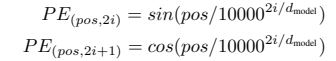

57398


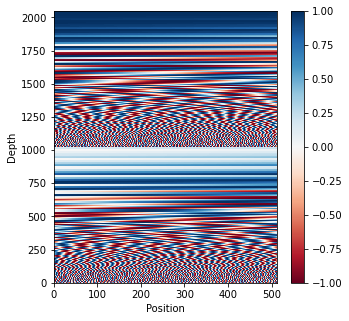

In [14]:
def positionalEncode(TimeSteps=5, modeldim=2):
    positionEmbbeddings = np.zeros((TimeSteps, modeldim))
    even=True
    for position in range(TimeSteps):
        for i in range(modeldim):
            v=position / np.power(10000, ((2*(np.float32(i)//2))/np.float32(modeldim)))
            if even: positionEmbbeddings[position][i]=np.sin(v)
            else:positionEmbbeddings[position][i]=np.cos(v)
            even = not even
    return positionEmbbeddings

TimeSteps,modeldim=2048, 512
pos_encoding=positionalEncode(TimeSteps, modeldim)
pos_encoding = pos_encoding.reshape(TimeSteps, modeldim//2, 2)
pos_encoding = pos_encoding.transpose(2,1,0)
pos_encoding = pos_encoding.reshape(TimeSteps, modeldim)

In [35]:
#positionally encoded vectors
x=Input(shape=(5,2))
# z=Input(shape=(1,))(x)#positional encoding
# y=()(x)#value
# w=Add(z,y)

B= MultiHeadAttention(5,2,output_shape= (5,2)) (x)
# R=Add([A,B])
# out =Dense(4)(R)
# R=BatchNormalization()(R)
tf.keras.models.Model(inputs=x,outputs=R)

TypeError: call() missing 1 required positional argument: 'value'

In [104]:
from keras.optimizers import SGD
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10)]

def BILSTM_model(inputShape, lstm=5,activation='relu',optimizer='adam',hidden=16):
    M = Sequential()
#     M.add(LSTM(lstm,activation=tf.keras.layers.LeakyReLU(),return_sequences=True ,input_shape=inputShape))
#     M.add(Bidirectional(LSTM(5,activation="relu",return_sequences=False ,input_shape=trainX.shape[1:])))
#     M.add(Bidirectional(LSTM(lstm,input_shape=inputShape,return_sequences=True)))
#     M.add(Bidirectional(LSTM(lstm,return_sequences=True ,input_shape=inputShape)))
#     M.add(tf.keras.layers.LeakyReLU())
    M.add(LSTM(lstm,input_shape=inputShape,return_sequences=False))
#     M.add(LSTM(lstm,activation=tf.keras.layers.LeakyReLU(),return_sequences=False ,input_shape=inputShape))
#     M.add(MultiHeadAttention(lstm,lstm))
    M.add(Dense(hidden, activation=activation))
    M.add(Dense(1,activation="linear"))
#     M.compile(loss='mae', optimizer=SGD(lr=0.1, momentum=0.9))
    M.compile(optimizer='adam',loss='huber')
#     M.compile(loss='mean_squared_error', optimizer='adam')
#     model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])
#     M.compile(loss='mean_squared_logarithmic_error', optimizer=opt)
    return M
model=BILSTM_model(inputShape=tx.shape[1:],lstm=16,activation='relu',optimizer='adam',hidden=16)
# history = model.fit(tx, ty, epochs=500, shuffle=True, batch_size=75, validation_split=0.1, callbacks=callbacks)
# plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
# predictions=model.predict(vx)
# predictions.shape
# plotCompare(vy.values,predictions,["Y","P"])


tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [132]:
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10)]
x=Input(shape=(5,1))
y=LSTM(5,input_shape=(5,1),return_sequences=True)(x)
A=Concatenate()([y,x])
out=Dense(1)(A)
# L = MultiHeadAttention(num_heads=5,key_dim=5)(x)

model=tf.keras.models.Model(inputs=x,outputs=out)
model.compile(loss='mae', optimizer="adam")
history = model.fit(tx, ty, epochs=500, shuffle=True, batch_size=75, validation_split=0.1, callbacks=callbacks)
# model.summary()

Epoch 1/500
139/139 [==============================] - 2s 6ms/step - loss: 0.9399 - val_loss: 1.4676
Epoch 2/500
139/139 [==============================] - 0s 3ms/step - loss: 0.2888 - val_loss: 1.0855
Epoch 3/500
139/139 [==============================] - 0s 3ms/step - loss: 0.2808 - val_loss: 0.9649
Epoch 4/500
139/139 [==============================] - 0s 3ms/step - loss: 0.2756 - val_loss: 0.9278
Epoch 5/500
139/139 [==============================] - 0s 3ms/step - loss: 0.2773 - val_loss: 0.8946
Epoch 6/500
139/139 [==============================] - 0s 3ms/step - loss: 0.2750 - val_loss: 0.8634
Epoch 7/500
139/139 [==============================] - 0s 3ms/step - loss: 0.2805 - val_loss: 0.8243
Epoch 8/500
139/139 [==============================] - 0s 3ms/step - loss: 0.2668 - val_loss: 0.8146
Epoch 9/500
139/139 [==============================] - 0s 3ms/step - loss: 0.2736 - val_loss: 0.7688
Epoch 10/500
139/139 [==============================] - 0s 3ms/step - loss: 0.2797 - val_lo

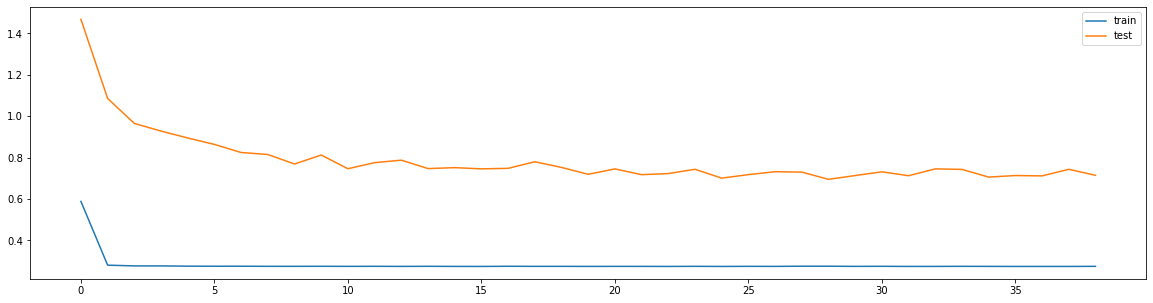

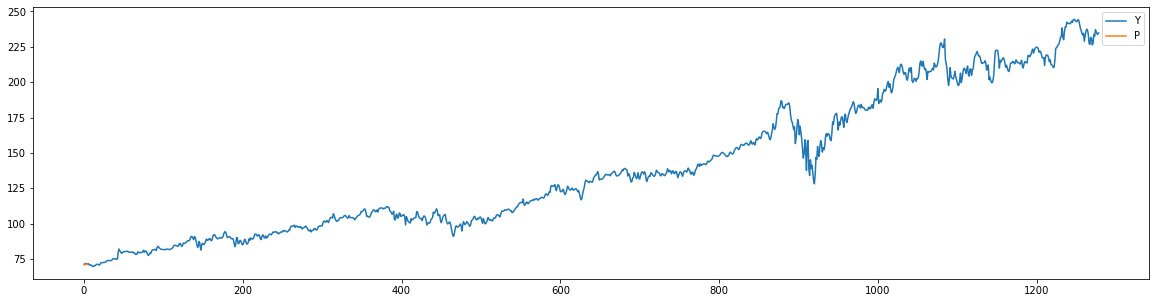

In [140]:
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
predictions=model.predict(vx)
plotCompare(vy.values,predictions[:][4],["Y","P"])

# Applying Sentiment to our models 

# Results